# CS224 - Spring 2025 - HW2 - Deepfake Cat Detector
Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 23, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Aryan Ramachandra
  </br>
  <b>Student ID Number</b>:  862545919
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment you will implement some classifiers to predict whether or not images of cats are "deepfakes", i.e., generated by AI. (I used SD 1.5, and down-sampled to match CIFAR-10, which we use for real images.)

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, scikit-learn (for cross validation utility and for baseline logistic regression), matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the parts marked `TODO` and print desired results. (In some cases, this just means getting the code to work so the TODO section prints the correct result.)

In [ ]:
import torch
# The following functions are discussed in week 5 demo
import torch.nn as nn  # neural net layers and activations
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset  # Super useful data utilities!

# We discussed all these in week 4 demo:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Used for visualization
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Turn off some annoying convergence warnings from sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## **Obtain and inspect data [3 points]**
You can download the data file here:
 https://elearn.ucr.edu/courses/169673/files/17302822/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

<ipython-input-2-c3db27e095f2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X, y = torch.load('hw2_data.pt')


Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



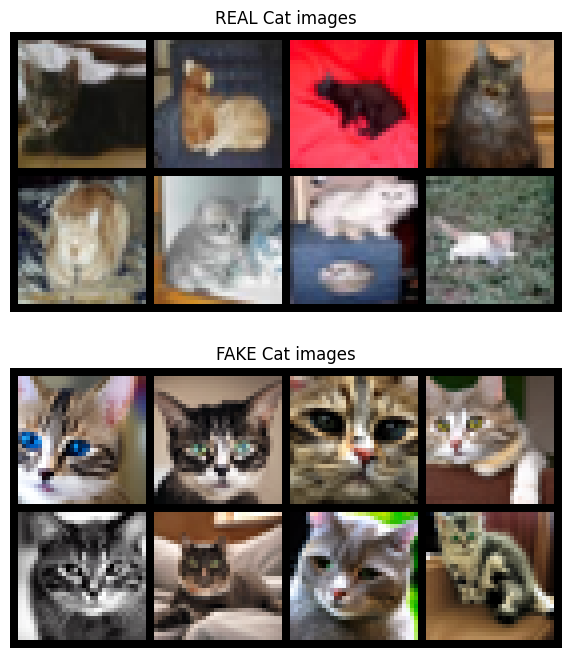

In [ ]:
# Load dataset and visualize
X, y = torch.load('hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Print examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))


X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [ ]:
# TODO [3 points]:
# Use scikit-learn logistic regression (with default hyper-parameters)
# with 5-fold CV to get the train and validation accuracies
# for a simple linear classifier - a good baseline for our MLP
n_folds = 5
val_accs = []  # store validation accuracy for each fold
train_accs = []  # store training accuracy for each fold

kf = KFold(n_splits=n_folds, shuffle=True)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Compute and store accuracy on train data
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_accs.append(train_acc)

    # Compute and store accuracy on validation data
    val_acc = accuracy_score(y_val, model.predict(X_val))
    val_accs.append(val_acc)

train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

# Standard error is standard deviation / sqrt(n), it is more typical to report this
rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
print(f'Train Accuracy and standard error:\t {train_mean:.3f} +/- {train_std / rootn:.3f}')
print(f'Validation Accuracy and standard error:\t {val_mean:.3f} +/- {val_std / rootn:.3f}')

Train Accuracy and standard error:	 0.982 +/- 0.002
Validation Accuracy and standard error:	 0.618 +/- 0.011


## Define the model [3 points]

- As always, implement an __init__ function and a forward function
- Use Linear layers with ReLU activations for the hidden layers
- 2 layers of hidden units. First layer has 128 hidden units, second layer has 64 hidden units.
- Output represents *binary* logits (must have correct shape to do that!)

In [ ]:
class MyMLP(nn.Module):
    # Define a multilayer perceptron [3 points]. Criteria above
    def __init__(self):
        super(MyMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=3072, out_features=128),  # Assuming input size from 3*32*32
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)  # Binary logits output
        )

    def forward(self, x):
        return self.model(x)

## Train function [6 points]
Make a function to train your neural net, following week 5 example

In [ ]:
# TODO [3 points]: a function to train your model
# (this will called for each hyper-parameter and fold)
# Don't forget to set model.train() during training, then model.eval() after done
# It doesn't matter in this case, but is good practice to prevent future bugs.

def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case)
    and "criterion" as the loss function (CrossEntropyLoss in this case).
    """
    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.unsqueeze(1).float())  # Ensure correct shape
            loss.backward()
            optimizer.step()

        if verbose:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_x, val_y in val_loader:
                    val_outputs = model(val_x)
                    val_loss += criterion(val_outputs, val_y.unsqueeze(1).float()).item()
            print(f'Validation loss: {val_loss / len(val_loader)}')
            model.train()

Loop over hyper-parameters and do 5-fold cross-validation for each setting, saving the train and validation mean accuracy and standard error.

In [ ]:
# TODO [3 points]: Perform cross-validation to get train/val accuracy
# for all hyper-parameter settings in the list below.
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 100
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold

        kf = KFold(n_splits=n_folds, shuffle=True)
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            train_dataset = TensorDataset(X_train, y_train)
            val_dataset = TensorDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            model = MyMLP()
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

            train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)

            with torch.no_grad():
                train_correct = sum((torch.sigmoid(model(X_train)) > 0.5).squeeze().long() == y_train)
                train_acc = train_correct.item() / len(y_train)
                train_accs.append(train_acc)

                val_correct = sum((torch.sigmoid(model(X_val)) > 0.5).squeeze().long() == y_val)
                val_acc = val_correct.item() / len(y_val)
                val_accs.append(val_acc)

        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))
        train_se, val_se = train_std / rootn, val_std / rootn

        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))



## Show result [3 points] - Extra Credit done below

In [ ]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.787 +/- 0.002,0.998 +/- 0.001,1.000 +/- 0.000
0.01,0.779 +/- 0.006,0.998 +/- 0.000,0.999 +/- 0.000


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.750 +/- 0.012,0.811 +/- 0.009,0.815 +/- 0.012
0.01,0.746 +/- 0.011,0.808 +/- 0.009,0.822 +/- 0.007


### Exporting the Notebook to PDF
To generate a nice looking PDF of your completed notebook, either use "Print" as PDF from Google colab (using Chrome), or if you are running locally, run the following command in the last cell:
```python
!jupyter nbconvert --to pdf --output=yourname_submission.pdf hw1.ipynb
```

## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point (and if you do multiple there will be a maximum of 2 extra points).
- Use t-SNE or UMAP to visualize a 2-d embedding of all the points, and see if the real and fake images are separable in the 2-d space.
- Use a more complex vision backbone like a pretrained ResNet to first embed the images, then train your MLP. You'll have to be careful to transform the images before input into a ResNet, as they usually expect a specific resolution. You can use torchvision transforms library for this. Does this increase accuracy? I don't know, but I speculate it won't help much - these embeddings are trained for classification accuracy, so they have no reason to preserve differences that are useful for finding fakes.
- Train a more complex vision backbone, instead of using the MLP. Again, a ResNet or a small vision transformer would be interesting. I think this would be the most typical and effective approach.
- Being an expert at hyper-parameter tuning is a skill that will benefit you greatly. Try a more fancy way to do this, like https://docs.wandb.ai, and see how well you can do on this assigment if you also vary other hyper-parameters (architecture, n_epochs, maybe early stopping, more learning rate/weight decay settings, regularizers, etc.)

Of course you can train your deepfake detector on my fakes, but how well will it do on ones from some other system? This is the fundamental research question in that field - how to build robust detectors that will work well even on new image generators.

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


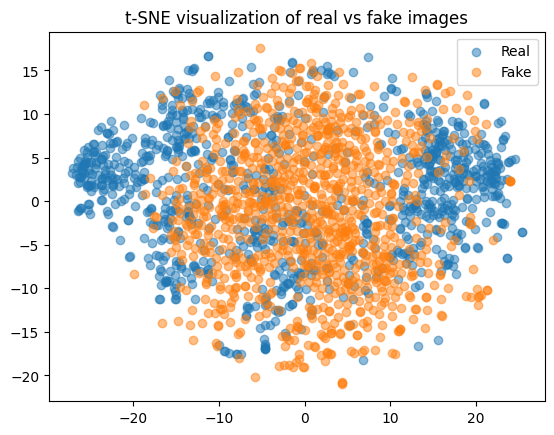

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)
plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], label='Real', alpha=0.5)
plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], label='Fake', alpha=0.5)
plt.legend()
plt.title('t-SNE visualization of real vs fake images')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


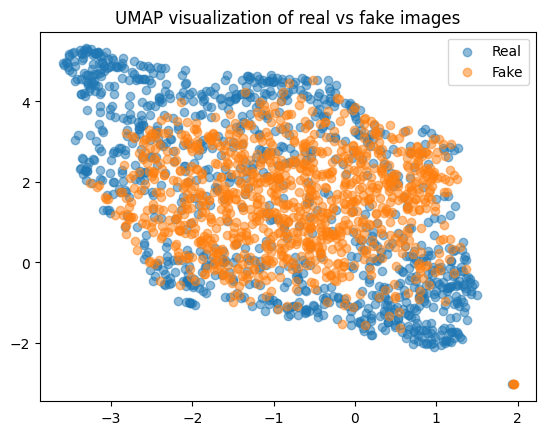

In [ ]:
import matplotlib.pyplot as plt
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)

X_embedded_umap = umap_model.fit_transform(X)

plt.scatter(X_embedded_umap[y==0, 0], X_embedded_umap[y==0, 1], label='Real', alpha=0.5)
plt.scatter(X_embedded_umap[y==1, 0], X_embedded_umap[y==1, 1], label='Fake', alpha=0.5)
plt.legend()
plt.title('UMAP visualization of real vs fake images')
plt.show()


# **Conclusion for extra Credit - Umap and Tsne**

The UMAP visualization provides better separation between real and fake images compared to t-SNE, as it maintains more distinct clusters while preserving global structure. In contrast, t-SNE shows a higher degree of intermixing between real and fake images, making classification more challenging. While UMAP highlights broader patterns, making it more interpretable for distinguishing real from fake images, t-SNE focuses on local relationships, leading to less structured global separation. Overall, UMAP appears to be the better choice for this task, but a quantitative analysis, such as silhouette scores or classification accuracy, could further validate these observations.